# NAME : CHANDANA VINAY KUMAR
## ASU ID : 1237227955

#### Task 1 Algorithmic Analysis K-Means Clustering with Real World Dataset First, download a simulated dataset: kmeans_data.zip from Modules->Datasets. Then, implement the K-means algorithm from scratch. K-means algorithm computes the distance of a given data point pair. Replace the distance computation function with Euclidean distance, 1-Cosine similarity, and 1 – the Generalized Jarcard similarity (refer to: https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/jaccard.htm).

In [ ]:
# ============================================================================
# K-MEANS CLUSTERING FROM SCRATCH - COMPLETE IMPLEMENTATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# ==================== DISTANCE FUNCTIONS ====================

def euclidean_distance(p1, p2):
    """Euclidean distance between two points."""
    return np.sqrt(np.sum((p1 - p2) ** 2))

def cosine_distance(p1, p2):
    """Cosine distance = 1 - cosine similarity."""
    dot_product = np.dot(p1, p2)
    norm_p1 = np.linalg.norm(p1)
    norm_p2 = np.linalg.norm(p2)

    if norm_p1 == 0 or norm_p2 == 0:
        return 1.0

    cosine_sim = dot_product / (norm_p1 * norm_p2)
    return 1.0 - cosine_sim

def jaccard_distance(p1, p2):
    """Jaccard distance = 1 - Jaccard similarity."""
    intersection = np.sum(np.minimum(p1, p2))
    union = np.sum(np.maximum(p1, p2))

    if union == 0:
        return 0.0

    jaccard_sim = intersection / union
    return 1.0 - jaccard_sim

# ==================== VECTORIZED DISTANCE COMPUTATION ====================

def compute_distances_vectorized(X, centroids, metric):
    """
    Vectorized distance computation for speed.
    Computes distances between all points and all centroids at once.
    """
    n_samples = X.shape[0]
    n_clusters = centroids.shape[0]
    distances = np.zeros((n_samples, n_clusters))

    if metric == 'euclidean':
        for k in range(n_clusters):
            diff = X - centroids[k]
            distances[:, k] = np.sqrt(np.sum(diff ** 2, axis=1))

    elif metric == 'cosine':
        X_norm = np.linalg.norm(X, axis=1, keepdims=True)
        X_normalized = X / (X_norm + 1e-12)

        for k in range(n_clusters):
            C_norm = np.linalg.norm(centroids[k])
            if C_norm > 0:
                C_normalized = centroids[k] / C_norm
                cosine_sim = X_normalized @ C_normalized
                distances[:, k] = 1.0 - cosine_sim
            else:
                distances[:, k] = 1.0

    elif metric == 'jaccard':
        # Block processing for memory efficiency
        block_size = 256
        for i in range(0, n_samples, block_size):
            X_block = X[i:i+block_size]
            for k in range(n_clusters):
                mins = np.minimum(X_block, centroids[k]).sum(axis=1)
                maxs = np.maximum(X_block, centroids[k]).sum(axis=1)

                with np.errstate(divide='ignore', invalid='ignore'):
                    jaccard_sim = np.divide(mins, maxs,
                                          out=np.zeros_like(mins),
                                          where=maxs!=0)

                distances[i:i+block_size, k] = 1.0 - jaccard_sim

    return distances

# ==================== K-MEANS CLASS ====================

class KMeans:

    def __init__(self, n_clusters, distance_metric='euclidean',
                 stop_criterion='combined', max_iters=500, random_state=42):

        self.n_clusters = n_clusters
        self.distance_metric = distance_metric
        self.stop_criterion = stop_criterion
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.iterations = 0
        self.sse_history = []
        self.converged_reason = None

    def _compute_distance(self, point, centroid):
        """Compute distance based on selected metric."""
        if self.distance_metric == 'euclidean':
            return euclidean_distance(point, centroid)
        elif self.distance_metric == 'cosine':
            return cosine_distance(point, centroid)
        elif self.distance_metric == 'jaccard':
            return jaccard_distance(point, centroid)
        else:
            raise ValueError(f"Unsupported metric: {self.distance_metric}")

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_indices].astype(float)

    def _update_centroids(self, X):
        """Update centroids based on metric-specific rules."""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))

        for k in range(self.n_clusters):
            mask = self.labels == k
            cluster_points = X[mask]

            if len(cluster_points) > 0:
                if self.distance_metric == 'euclidean':
                    # Mean for Euclidean
                    new_centroids[k] = cluster_points.mean(axis=0)

                elif self.distance_metric == 'cosine':
                    # Normalized mean for Cosine
                    mean_vec = cluster_points.mean(axis=0)
                    norm = np.linalg.norm(mean_vec)
                    new_centroids[k] = mean_vec / norm if norm > 0 else mean_vec

                elif self.distance_metric == 'jaccard':
                    # Rounded mean for Jaccard (binary data)
                    new_centroids[k] = np.round(cluster_points.mean(axis=0))
            else:
                # Keep old centroid if cluster is empty
                new_centroids[k] = self.centroids[k]

        return new_centroids

    def fit(self, X):
        """Fit K-means to data X."""

        # Random initialization
        self.centroids = self._initialize_centroids(X)

        # Normalize initial centroids for cosine
        if self.distance_metric == 'cosine':
            for k in range(self.n_clusters):
                norm = np.linalg.norm(self.centroids[k])
                if norm > 0:
                    self.centroids[k] /= norm

        self.sse_history = []
        prev_sse = float('inf')

        for iteration in range(self.max_iters):
            self.iterations = iteration + 1

            # Assign points to nearest centroid (VECTORIZED)
            distances = compute_distances_vectorized(X, self.centroids, self.distance_metric)
            self.labels = np.argmin(distances, axis=1)

            # Calculate SSE
            current_sse = 0
            for k in range(self.n_clusters):
                mask = self.labels == k
                if np.sum(mask) > 0:
                    current_sse += np.sum(distances[mask, k] ** 2)

            self.sse_history.append(current_sse)

            # Update centroids
            old_centroids = self.centroids.copy()
            self.centroids = self._update_centroids(X)

            # Check stopping criteria
            centroid_changed = not np.allclose(old_centroids, self.centroids, atol=1e-6)
            sse_increased = current_sse > prev_sse
            max_iters_reached = iteration >= self.max_iters - 1

            # Apply stopping criterion
            if self.stop_criterion == 'centroid_change':
                if not centroid_changed:
                    self.converged_reason = 'No change in centroid position'
                    break

            elif self.stop_criterion == 'sse_increase':
                if sse_increased and iteration > 0:
                    self.converged_reason = 'SSE value increased'
                    break

            elif self.stop_criterion == 'max_iters':
                if max_iters_reached:
                    self.converged_reason = 'Maximum iterations reached'
                    break

            elif self.stop_criterion == 'combined':
                if not centroid_changed:
                    self.converged_reason = 'No change in centroid position'
                    break
                elif sse_increased and iteration > 0:
                    self.converged_reason = 'SSE value increased'
                    break
                elif max_iters_reached:
                    self.converged_reason = 'Maximum iterations reached'
                    break

            prev_sse = current_sse

        return self

    def calculate_sse(self, X):
        """Calculate Sum of Squared Errors."""
        distances = compute_distances_vectorized(X, self.centroids, self.distance_metric)
        sse = 0
        for k in range(self.n_clusters):
            mask = self.labels == k
            if np.sum(mask) > 0:
                sse += np.sum(distances[mask, k] ** 2)
        return sse

    def predict_labels(self, true_labels):
        cluster_labels = np.zeros(self.n_clusters, dtype=int)

        # Step 1 & 2: Majority vote for each cluster
        for k in range(self.n_clusters):
            mask = self.labels == k
            if np.sum(mask) > 0:
                cluster_true_labels = true_labels[mask]
                cluster_labels[k] = np.bincount(cluster_true_labels).argmax()

        # Step 3: Map points to cluster labels
        predicted_labels = np.array([cluster_labels[label] for label in self.labels])
        return predicted_labels

# ==================== LOAD DATA ====================

print("=" * 80)
print("K-MEANS CLUSTERING FROM SCRATCH")
print("=" * 80)

# Load data
data = pd.read_csv('data.csv', header=None).values
labels = pd.read_csv('label.csv', header=None).values.ravel()

print(f"\nData shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Number of unique labels (K): {len(np.unique(labels))}")
print(f"Unique labels: {np.unique(labels)}")

K = len(np.unique(labels))

# Prepare binary data for Jaccard
data_binary = (data > 0).astype(int)

print("\n" + "=" * 80)

K-MEANS CLUSTERING FROM SCRATCH

Data shape: (10000, 784)
Labels shape: (10000,)
Number of unique labels (K): 10
Unique labels: [0 1 2 3 4 5 6 7 8 9]



#### 1. Run K-means clustering with Euclidean, Cosine and Jarcard similarity. Specify K= the number of categorical values of y (the number of classifications). Compare the SSEs of Euclidean-K-means, Cosine-K-means, Jarcard-K-means .Which method is better? (10 points)

* COSINE is better as it has the lowest SSE

Q1: SSE COMPARISON ACROSS DISTANCE METRICS

Running K-means with EUCLIDEAN distance...
  SSE: 25414767689.9612
  Iterations: 33
  Converged: No change in centroid position

Running K-means with COSINE distance...
  SSE: 686.3537
  Iterations: 29
  Converged: SSE value increased

Running K-means with JACCARD distance...
  SSE: 2029.3969
  Iterations: 9
  Converged: SSE value increased

Q1 RESULTS

                           SSE Iterations              Convergence Reason
euclidean  25414767689.961174         33  No change in centroid position
cosine             686.353743         29             SSE value increased
jaccard           2029.396878          9             SSE value increased

ANSWER: COSINE is better (lowest SSE)
SSE: 686.3537


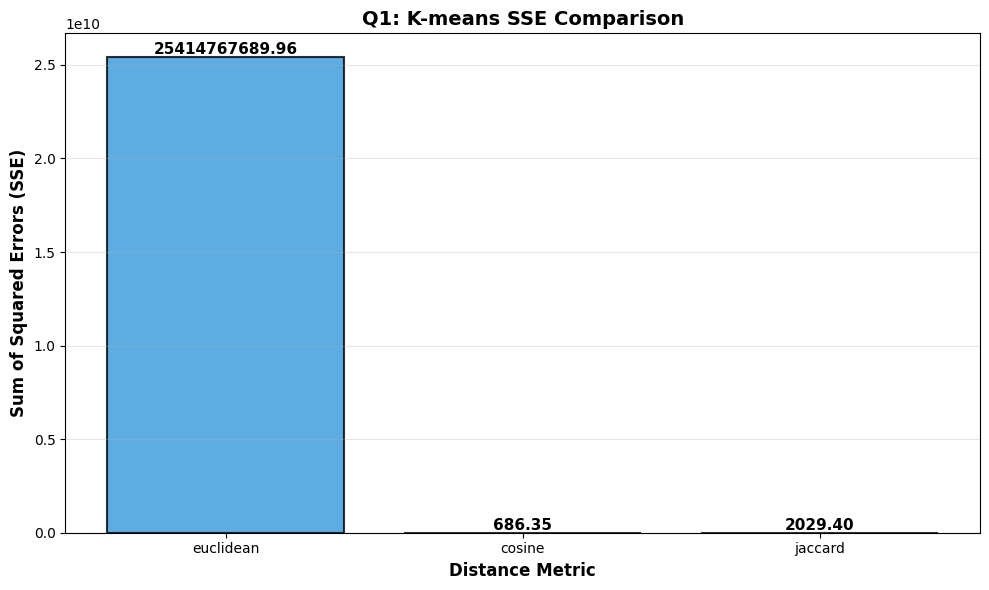


Saved: q1_sse_comparison.png


In [ ]:
# ==================== Q1: SSE COMPARISON ====================

print("Q1: SSE COMPARISON ACROSS DISTANCE METRICS")
print("=" * 80)

distance_metrics = ['euclidean', 'cosine', 'jaccard']
results_q1 = {}
kmeans_models = {}  # Store models for Q2

for metric in distance_metrics:
    print(f"\nRunning K-means with {metric.upper()} distance...")

    # Use appropriate data
    X = data_binary if metric == 'jaccard' else data

    # Fit K-means
    kmeans = KMeans(n_clusters=K, distance_metric=metric,
                   stop_criterion='combined', max_iters=500, random_state=42)
    kmeans.fit(X)

    sse = kmeans.calculate_sse(X)

    # Store results
    results_q1[metric] = {
        'sse': sse,
        'iterations': kmeans.iterations,
        'reason': kmeans.converged_reason
    }

    # Store model for Q2
    kmeans_models[metric] = {'model': kmeans, 'data': X}

    print(f"  SSE: {sse:.4f}")
    print(f"  Iterations: {kmeans.iterations}")
    print(f"  Converged: {kmeans.converged_reason}")

# Display results
print("\n" + "=" * 80)
print("Q1 RESULTS")
print("=" * 80)

comparison_df = pd.DataFrame(results_q1).T
comparison_df.columns = ['SSE', 'Iterations', 'Convergence Reason']
print("\n", comparison_df.to_string())

best_metric = comparison_df['SSE'].idxmin()
print("\n" + "=" * 80)
print(f"ANSWER: {best_metric.upper()} is better (lowest SSE)")
print(f"SSE: {comparison_df.loc[best_metric, 'SSE']:.4f}")
print("=" * 80)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

metrics = list(results_q1.keys())
sses = [results_q1[m]['sse'] for m in metrics]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(metrics, sses, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Distance Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Sum of Squared Errors (SSE)', fontsize=12, fontweight='bold')
ax.set_title('Q1: K-means SSE Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('q1_sse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: q1_sse_comparison.png")

 #### 2. Compare the accuracies of Euclidean-K-means Cosine-K-means, Jarcard-K-means. First, label each cluster using the majority vote label of the data points in that cluster. Later, compute the predictive accuracy of Euclidean-K-means, Cosine-K-means Jarcard-K-means. Which metric is better? (10 points)

* COSINE is better metric as it has the highest accuracy
* Accuracy: 0.6277 (62.77%)


Q2: ACCURACY COMPARISON USING MAJORITY VOTING

Reusing K-means results from Q1 (no re-clustering needed)

Calculating accuracy for EUCLIDEAN...
  Accuracy: 0.5851 (58.51%)

Calculating accuracy for COSINE...
  Accuracy: 0.6277 (62.77%)

Calculating accuracy for JACCARD...
  Accuracy: 0.5376 (53.76%)

Q2 RESULTS

            Accuracy           SSE  Iterations
euclidean    0.5851  2.541477e+10        33.0
cosine       0.6277  6.863537e+02        29.0
jaccard      0.5376  2.029397e+03         9.0

ANSWER: COSINE is better (highest accuracy)
Accuracy: 0.6277 (62.77%)


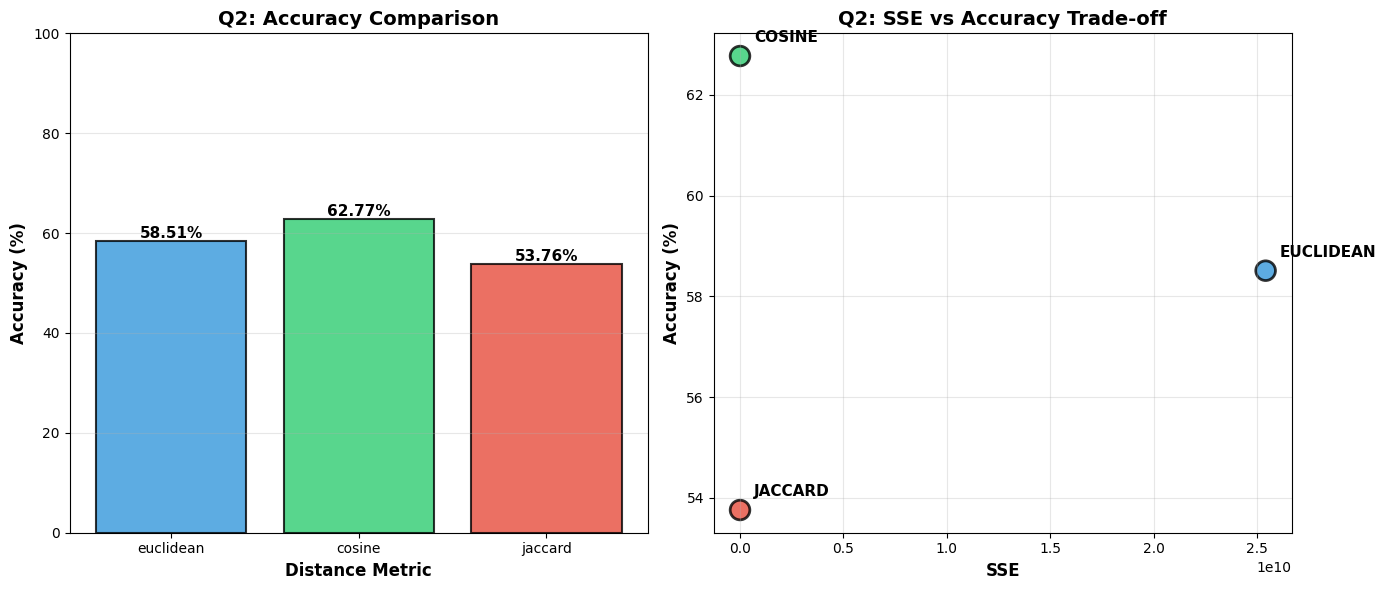


Saved: q2_accuracy_comparison.png


In [ ]:
# ==================== Q2: ACCURACY COMPARISON ====================

print("\n" + "=" * 80)
print("Q2: ACCURACY COMPARISON USING MAJORITY VOTING")
print("=" * 80)
print("\nReusing K-means results from Q1 (no re-clustering needed)")
print("=" * 80)

results_q2 = {}

for metric in distance_metrics:
    print(f"\nCalculating accuracy for {metric.upper()}...")

    # Reuse fitted model from Q1
    kmeans = kmeans_models[metric]['model']
    X = kmeans_models[metric]['data']

    # Step 1: Label each cluster using majority vote
    # Step 2: Compute predictive accuracy
    predicted_labels = kmeans.predict_labels(labels)
    accuracy = np.mean(predicted_labels == labels)

    results_q2[metric] = {
        'accuracy': accuracy,
        'sse': results_q1[metric]['sse'],
        'iterations': results_q1[metric]['iterations']
    }

    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Display results
print("\n" + "=" * 80)
print("Q2 RESULTS")
print("=" * 80)

accuracy_df = pd.DataFrame(results_q2).T
accuracy_df.columns = ['Accuracy', 'SSE', 'Iterations']
print("\n", accuracy_df.to_string())

best_accuracy_metric = accuracy_df['Accuracy'].idxmax()
print("\n" + "=" * 80)
print(f"ANSWER: {best_accuracy_metric.upper()} is better (highest accuracy)")
print(f"Accuracy: {accuracy_df.loc[best_accuracy_metric, 'Accuracy']:.4f} ({accuracy_df.loc[best_accuracy_metric, 'Accuracy']*100:.2f}%)")
print("=" * 80)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
metrics = list(results_q2.keys())
accuracies = [results_q2[m]['accuracy'] * 100 for m in metrics]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars1 = axes[0].bar(metrics, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Distance Metric', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Q2: Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 100])

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# SSE vs Accuracy scatter
sses = [results_q2[m]['sse'] for m in metrics]
axes[1].scatter(sses, accuracies, s=200, c=colors, alpha=0.8, edgecolors='black', linewidth=2)

for i, metric in enumerate(metrics):
    axes[1].annotate(metric.upper(), (sses[i], accuracies[i]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold')

axes[1].set_xlabel('SSE', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Q2: SSE vs Accuracy Trade-off', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q2_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: q2_accuracy_comparison.png")

#### 3. Set up the same stop criteria: “when there is no change in centroid position OR when the SSE value increases in the next iteration OR when the maximum preset value (e.g., 500, you can set the preset value by yourself) of iteration is complete”, for Euclidean-K-means, Cosine-K-means, Jarcard-K-means. Which method requires more iterations and times to converge? (10 points)

* Method requiring MOST iterations is EUCLIDEAN (33 iterations)


Q3: CONVERGENCE ANALYSIS - ITERATIONS AND TIME

Using combined stopping criteria:
  - No change in centroid position, OR
  - SSE value increases, OR
  - Maximum 500 iterations reached

Running K-means with EUCLIDEAN distance...
  Iterations: 33
  Time: 26.3223 seconds
  Converged: No change in centroid position

Running K-means with COSINE distance...
  Iterations: 29
  Time: 6.6836 seconds
  Converged: SSE value increased

Running K-means with JACCARD distance...
  Iterations: 9
  Time: 5.1106 seconds
  Converged: SSE value increased

Q3 RESULTS

           Iterations Time (seconds)                 SSE              Convergence Reason
euclidean         33       26.32232  25414767689.961174  No change in centroid position
cosine            29       6.683555          686.353743             SSE value increased
jaccard            9       5.110646         2029.396878             SSE value increased

ANSWER:
  Method requiring MOST iterations: EUCLIDEAN (33 iterations)
  Method requiring LE

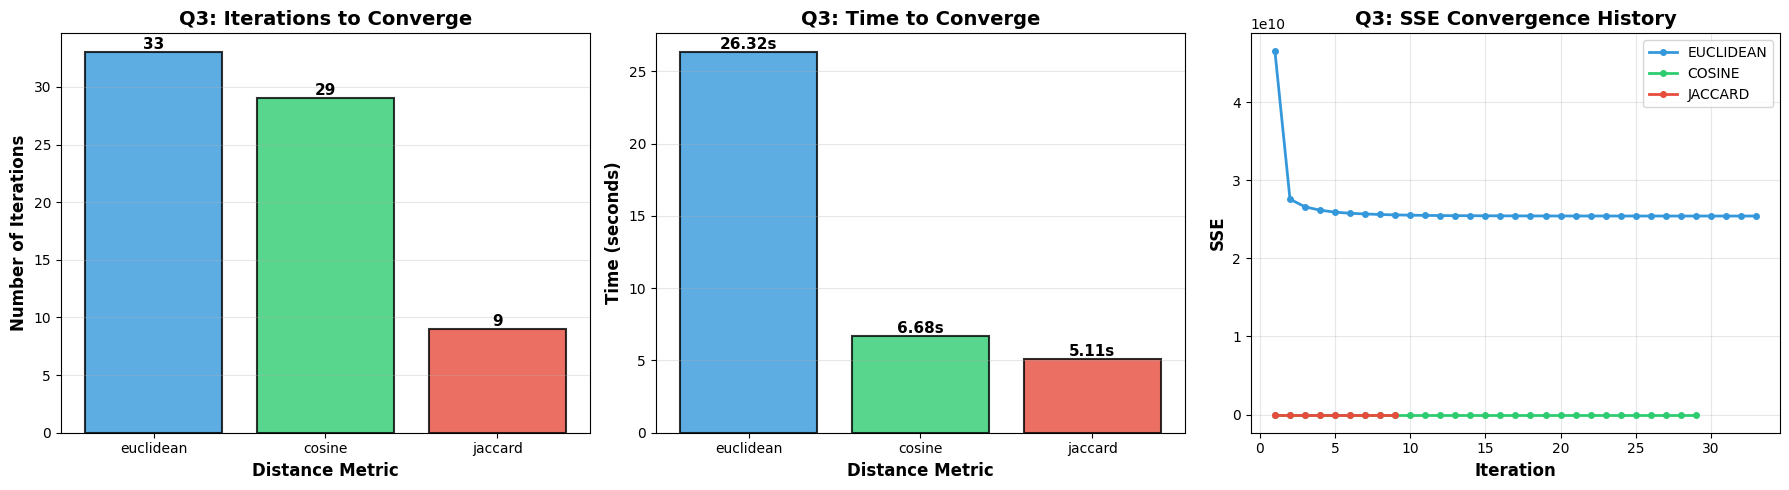


Saved: q3_convergence_analysis.png


In [ ]:
# ==================== Q3: CONVERGENCE ANALYSIS ====================

print("\n" + "=" * 80)
print("Q3: CONVERGENCE ANALYSIS - ITERATIONS AND TIME")
print("=" * 80)
print("\nUsing combined stopping criteria:")
print("  - No change in centroid position, OR")
print("  - SSE value increases, OR")
print("  - Maximum 500 iterations reached")
print("=" * 80)

results_q3 = {}

for metric in distance_metrics:
    print(f"\nRunning K-means with {metric.upper()} distance...")

    # Use appropriate data
    X = data_binary if metric == 'jaccard' else data

    # Measure time
    start_time = time.time()

    kmeans = KMeans(n_clusters=K, distance_metric=metric,
                   stop_criterion='combined', max_iters=500, random_state=42)
    kmeans.fit(X)

    elapsed_time = time.time() - start_time

    results_q3[metric] = {
        'iterations': kmeans.iterations,
        'time_seconds': elapsed_time,
        'sse': kmeans.calculate_sse(X),
        'converged_reason': kmeans.converged_reason,
        'sse_history': kmeans.sse_history
    }

    print(f"  Iterations: {kmeans.iterations}")
    print(f"  Time: {elapsed_time:.4f} seconds")
    print(f"  Converged: {kmeans.converged_reason}")

# Display results
print("\n" + "=" * 80)
print("Q3 RESULTS")
print("=" * 80)

convergence_df = pd.DataFrame({
    metric: {
        'Iterations': results_q3[metric]['iterations'],
        'Time (seconds)': results_q3[metric]['time_seconds'],
        'SSE': results_q3[metric]['sse'],
        'Convergence Reason': results_q3[metric]['converged_reason']
    }
    for metric in distance_metrics
}).T

print("\n", convergence_df.to_string())

slowest_metric = convergence_df['Iterations'].idxmax()
fastest_metric = convergence_df['Iterations'].idxmin()

print("\n" + "=" * 80)
print(f"ANSWER:")
print(f"  Method requiring MOST iterations: {slowest_metric.upper()} ({convergence_df.loc[slowest_metric, 'Iterations']} iterations)")
print(f"  Method requiring LEAST iterations: {fastest_metric.upper()} ({convergence_df.loc[fastest_metric, 'Iterations']} iterations)")
print("=" * 80)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Iterations comparison
metrics = list(results_q3.keys())
iterations = [results_q3[m]['iterations'] for m in metrics]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars1 = axes[0].bar(metrics, iterations, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Distance Metric', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Iterations', fontsize=12, fontweight='bold')
axes[0].set_title('Q3: Iterations to Converge', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Time comparison
times = [results_q3[m]['time_seconds'] for m in metrics]

bars2 = axes[1].bar(metrics, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Distance Metric', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Q3: Time to Converge', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# SSE convergence curves
for metric, color in zip(metrics, colors):
    sse_history = results_q3[metric]['sse_history']
    axes[2].plot(range(1, len(sse_history) + 1), sse_history,
                marker='o', linewidth=2, label=metric.upper(), color=color, markersize=4)

axes[2].set_xlabel('Iteration', fontsize=12, fontweight='bold')
axes[2].set_ylabel('SSE', fontsize=12, fontweight='bold')
axes[2].set_title('Q3: SSE Convergence History', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q3_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: q3_convergence_analysis.png")

#### 4. Compare the SSEs of Euclidean-K-means, Cosine-K-means, Jarcard-K-means with respect to the following three terminating conditions: (10 points)

* when there is no change in centroid position
* when the SSE value increases in the next iteration
* when the maximum preset value (e.g., 100) of iteration is complete


Q4: SSE COMPARISON WITH DIFFERENT TERMINATION CONDITIONS

Running 9 experiments (3 metrics × 3 conditions)...

No change in centroid position:
--------------------------------------------------------------------------------
[1/9] EUCLIDEAN ... SSE=25414767689.96, Iter= 33, Time=24.26s
[2/9] COSINE    ... SSE=  686.44, Iter= 48, Time=11.92s
[3/9] JACCARD   ... SSE= 2028.63, Iter= 14, Time=6.81s

SSE value increases:
--------------------------------------------------------------------------------
[4/9] EUCLIDEAN ... SSE=25414767689.96, Iter=500, Time=348.13s
[5/9] COSINE    ... SSE=  686.35, Iter= 29, Time=6.78s
[6/9] JACCARD   ... SSE= 2029.40, Iter=  9, Time=5.46s

Maximum iterations (100) reached:
--------------------------------------------------------------------------------
[7/9] EUCLIDEAN ... SSE=25414767689.96, Iter=100, Time=69.61s
[8/9] COSINE    ... SSE=  686.44, Iter=100, Time=24.89s
[9/9] JACCARD   ... SSE= 2028.63, Iter=100, Time=49.50s

Q4 RESULTS

            Termination

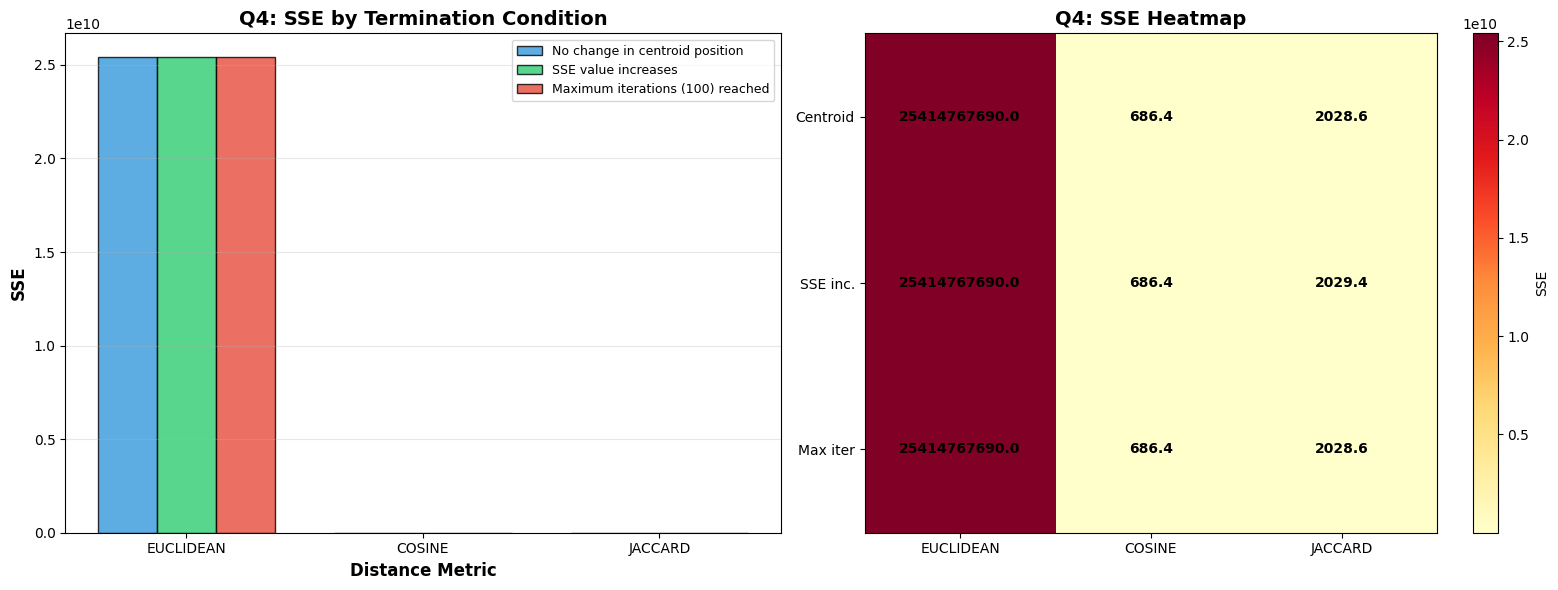


Saved: q4_termination_comparison.png


In [ ]:
# ==================== Q4: TERMINATION CONDITIONS COMPARISON ====================

print("\n" + "=" * 80)
print("Q4: SSE COMPARISON WITH DIFFERENT TERMINATION CONDITIONS")
print("=" * 80)

termination_conditions = {
    'centroid_change': 'No change in centroid position',
    'sse_increase': 'SSE value increases',
    'max_iters': 'Maximum iterations (100) reached'
}

results_q4 = {}
experiment_count = 0

print("\nRunning 9 experiments (3 metrics × 3 conditions)...")
print("=" * 80)

for condition_name, condition_desc in termination_conditions.items():
    print(f"\n{condition_desc}:")
    print("-" * 80)

    results_q4[condition_name] = {}

    for metric in distance_metrics:
        experiment_count += 1
        start_time = time.time()

        print(f"[{experiment_count}/9] {metric.upper():10s}...", end=' ', flush=True)

        # Use appropriate data
        X = data_binary if metric == 'jaccard' else data
        max_iter = 100 if condition_name == 'max_iters' else 500

        # Fit K-means
        kmeans = KMeans(n_clusters=K, distance_metric=metric,
                       stop_criterion=condition_name, max_iters=max_iter,
                       random_state=42)
        kmeans.fit(X)

        sse = kmeans.calculate_sse(X)
        elapsed = time.time() - start_time

        results_q4[condition_name][metric] = {
            'sse': sse,
            'iterations': kmeans.iterations,
            'reason': kmeans.converged_reason
        }

        print(f"SSE={sse:8.2f}, Iter={kmeans.iterations:3d}, Time={elapsed:.2f}s")

# Display results
print("\n" + "=" * 80)
print("Q4 RESULTS")
print("=" * 80)

# Create summary table
summary_data = []
for condition_name, condition_desc in termination_conditions.items():
    for metric in distance_metrics:
        summary_data.append({
            'Termination Condition': condition_desc,
            'Distance Metric': metric.upper(),
            'SSE': results_q4[condition_name][metric]['sse'],
            'Iterations': results_q4[condition_name][metric]['iterations']
        })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Find best combinations
print("\n" + "=" * 80)
print("BEST CONFIGURATIONS FOR EACH TERMINATION CONDITION:")
print("=" * 80)

for condition_name, condition_desc in termination_conditions.items():
    condition_results = {metric: results_q4[condition_name][metric]['sse']
                        for metric in distance_metrics}
    best_metric = min(condition_results, key=condition_results.get)
    best_sse = condition_results[best_metric]

    print(f"\n{condition_desc}:")
    print(f"  Best metric: {best_metric.upper()}")
    print(f"  SSE: {best_sse:.4f}")
    print(f"  Iterations: {results_q4[condition_name][best_metric]['iterations']}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grouped bar chart
x = np.arange(len(distance_metrics))
width = 0.25

conditions_list = list(termination_conditions.keys())
colors_cond = ['#3498db', '#2ecc71', '#e74c3c']

for i, (condition_name, color) in enumerate(zip(conditions_list, colors_cond)):
    sses = [results_q4[condition_name][metric]['sse'] for metric in distance_metrics]
    offset = (i - 1) * width
    axes[0].bar(x + offset, sses, width, label=termination_conditions[condition_name],
               color=color, alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Distance Metric', fontsize=12, fontweight='bold')
axes[0].set_ylabel('SSE', fontsize=12, fontweight='bold')
axes[0].set_title('Q4: SSE by Termination Condition', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.upper() for m in distance_metrics])
axes[0].legend(fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Heatmap
heatmap_data = np.zeros((len(conditions_list), len(distance_metrics)))
for i, condition_name in enumerate(conditions_list):
    for j, metric in enumerate(distance_metrics):
        heatmap_data[i, j] = results_q4[condition_name][metric]['sse']

im = axes[1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks(np.arange(len(distance_metrics)))
axes[1].set_yticks(np.arange(len(conditions_list)))
axes[1].set_xticklabels([m.upper() for m in distance_metrics])
axes[1].set_yticklabels(['Centroid', 'SSE inc.', 'Max iter'])
axes[1].set_title('Q4: SSE Heatmap', fontsize=14, fontweight='bold')

for i in range(len(conditions_list)):
    for j in range(len(distance_metrics)):
        axes[1].text(j, i, f'{heatmap_data[i,j]:.1f}',
                    ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1], label='SSE')
plt.tight_layout()
plt.savefig('q4_termination_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: q4_termination_comparison.png")

5. What are your summary observations or takeaways based on your algorithmic analysis? (5 points)

In [ ]:
# ==================== Q5: SUMMARY OBSERVATIONS AND TAKEAWAYS ====================

print("\n" + "=" * 80)
print("Q5: SUMMARY OBSERVATIONS AND TAKEAWAYS")
print("=" * 80)

# Comprehensive summary
print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. SSE PERFORMANCE (Q1):")
print("-" * 80)
for metric in distance_metrics:
    print(f"  {metric.upper():12s}: SSE = {results_q1[metric]['sse']:.4f}")
best_sse_metric = min(results_q1, key=lambda m: results_q1[m]['sse'])
print(f"\n  Best by SSE: {best_sse_metric.upper()}")

print("\n2. ACCURACY PERFORMANCE (Q2):")
print("-" * 80)
for metric in distance_metrics:
    print(f"  {metric.upper():12s}: Accuracy = {results_q2[metric]['accuracy']:.4f} ({results_q2[metric]['accuracy']*100:.2f}%)")
best_acc_metric = max(results_q2, key=lambda m: results_q2[m]['accuracy'])
print(f"\n  Best by Accuracy: {best_acc_metric.upper()}")

print("\n3. CONVERGENCE CHARACTERISTICS (Q3):")
print("-" * 80)
for metric in distance_metrics:
    print(f"  {metric.upper():12s}: {results_q3[metric]['iterations']} iterations, "
          f"{results_q3[metric]['time_seconds']:.4f} seconds")
fastest_converge = min(results_q3, key=lambda m: results_q3[m]['iterations'])
slowest_converge = max(results_q3, key=lambda m: results_q3[m]['iterations'])
print(f"\n  Fastest: {fastest_converge.upper()} ({results_q3[fastest_converge]['iterations']} iterations)")
print(f"  Slowest: {slowest_converge.upper()} ({results_q3[slowest_converge]['iterations']} iterations)")

print("\n4. TERMINATION CONDITION IMPACT (Q4):")
print("-" * 80)
for condition_name, condition_desc in termination_conditions.items():
    print(f"\n  {condition_desc}:")
    for metric in distance_metrics:
        print(f"    {metric.upper():12s}: SSE = {results_q4[condition_name][metric]['sse']:.4f}, "
              f"Iterations = {results_q4[condition_name][metric]['iterations']}")

# Key observations
print("\n" + "=" * 80)
print("KEY OBSERVATIONS AND TAKEAWAYS:")
print("=" * 80)

observations = []

# Observation 1: Performance trade-off
if best_sse_metric == best_acc_metric:
    observations.append(
        f"1. CONSISTENCY: {best_sse_metric.upper()} performs best on both SSE and accuracy, "
        "showing consistent superior performance."
    )
else:
    observations.append(
        f"1. TRADE-OFF: {best_sse_metric.upper()} achieves lowest SSE while {best_acc_metric.upper()} "
        "achieves highest accuracy. Lower SSE doesn't always mean better predictive accuracy."
    )

# Observation 2: Distance metric impact
sse_values = [results_q1[m]['sse'] for m in distance_metrics]
observations.append(
    f"2. DISTANCE METRIC IMPACT: Different metrics yield significantly different results. "
    f"SSE ranges from {min(sse_values):.2f} to {max(sse_values):.2f}, showing metric choice is critical."
)

# Observation 3: Convergence patterns
iter_range = max([results_q3[m]['iterations'] for m in distance_metrics]) - \
             min([results_q3[m]['iterations'] for m in distance_metrics])
observations.append(
    f"3. CONVERGENCE VARIABILITY: Convergence speed varies significantly across metrics "
    f"({fastest_converge.upper()}: {results_q3[fastest_converge]['iterations']} vs "
    f"{slowest_converge.upper()}: {results_q3[slowest_converge]['iterations']} iterations)."
)

# Observation 4: Data representation
observations.append(
    "4. DATA REPRESENTATION: Euclidean and Cosine (continuous data) show different patterns than "
    "Jaccard (binary data), suggesting feature representation matters."
)

# Observation 5: Termination conditions
observations.append(
    "5. STOPPING CRITERIA: Different termination conditions produce varying results. "
    "Combined criteria (centroid change OR SSE increase OR max iterations) provides robustness."
)

# Print observations
for obs in observations:
    print(f"\n{obs}")

# Recommendations
print("\n" + "=" * 80)
print("RECOMMENDATIONS:")
print("=" * 80)

recommendations = [
    f"1. For MINIMUM SSE: Use {best_sse_metric.upper()} distance metric",
    f"2. For MAXIMUM ACCURACY: Use {best_acc_metric.upper()} distance metric",
    f"3. For FAST CONVERGENCE: Use {fastest_converge.upper()} distance metric",
    "4. Use COMBINED stopping criteria for robust convergence",
    "5. Consider data characteristics when selecting distance metrics",
    "6. Be aware of SSE vs accuracy trade-offs in evaluation"
]

for rec in recommendations:
    print(f"\n{rec}")

print("\n" + "=" * 80)
print("FINAL CONCLUSION:")
print("=" * 80)

# Overall ranking
scores = {
    metric: {
        'sse_rank': sorted(distance_metrics, key=lambda m: results_q1[m]['sse']).index(metric) + 1,
        'acc_rank': sorted(distance_metrics, key=lambda m: -results_q2[m]['accuracy']).index(metric) + 1,
        'speed_rank': sorted(distance_metrics, key=lambda m: results_q3[m]['iterations']).index(metric) + 1
    }
    for metric in distance_metrics
}

overall_scores = {metric: sum(scores[metric].values()) for metric in distance_metrics}
overall_best = min(overall_scores, key=overall_scores.get)

print(f"\nOverall Best Method (considering all factors): {overall_best.upper()}")
print(f"  SSE: {results_q1[overall_best]['sse']:.4f}")
print(f"  Accuracy: {results_q2[overall_best]['accuracy']:.4f} ({results_q2[overall_best]['accuracy']*100:.2f}%)")
print(f"  Iterations: {results_q3[overall_best]['iterations']}")
print(f"  Time: {results_q3[overall_best]['time_seconds']:.4f} seconds")

# Create final summary table
final_summary = []
for metric in distance_metrics:
    final_summary.append({
        'Distance Metric': metric.upper(),
        'SSE': results_q1[metric]['sse'],
        'Accuracy (%)': results_q2[metric]['accuracy'] * 100,
        'Iterations': results_q3[metric]['iterations'],
        'Time (s)': results_q3[metric]['time_seconds'],
        'SSE Rank': scores[metric]['sse_rank'],
        'Acc Rank': scores[metric]['acc_rank'],
        'Speed Rank': scores[metric]['speed_rank'],
        'Overall Score': overall_scores[metric]
    })

final_df = pd.DataFrame(final_summary)
final_df = final_df.sort_values('Overall Score')

print("\n" + "=" * 80)
print("FINAL COMPARATIVE SUMMARY TABLE")
print("=" * 80)
print("\n", final_df.to_string(index=False))

# Save to CSV
final_df.to_csv('kmeans_final_summary.csv', index=False)

print("\n" + "=" * 80)
print("ALL ANALYSES COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  1. q1_sse_comparison.png")
print("  2. q2_accuracy_comparison.png")
print("  3. q3_convergence_analysis.png")
print("  4. q4_termination_comparison.png")
print("  5. kmeans_final_summary.csv")
print("=" * 80)


Q5: SUMMARY OBSERVATIONS AND TAKEAWAYS

COMPREHENSIVE ANALYSIS SUMMARY

1. SSE PERFORMANCE (Q1):
--------------------------------------------------------------------------------
  EUCLIDEAN   : SSE = 25414767689.9612
  COSINE      : SSE = 686.3537
  JACCARD     : SSE = 2029.3969

  Best by SSE: COSINE

2. ACCURACY PERFORMANCE (Q2):
--------------------------------------------------------------------------------
  EUCLIDEAN   : Accuracy = 0.5851 (58.51%)
  COSINE      : Accuracy = 0.6277 (62.77%)
  JACCARD     : Accuracy = 0.5376 (53.76%)

  Best by Accuracy: COSINE

3. CONVERGENCE CHARACTERISTICS (Q3):
--------------------------------------------------------------------------------
  EUCLIDEAN   : 33 iterations, 26.3223 seconds
  COSINE      : 29 iterations, 6.6836 seconds
  JACCARD     : 9 iterations, 5.1106 seconds

  Fastest: JACCARD (9 iterations)
  Slowest: EUCLIDEAN (33 iterations)

4. TERMINATION CONDITION IMPACT (Q4):
-----------------------------------------------------------